In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
pd.read_sql_table("measurement", engine).head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [97]:
pd.read_sql_table("station", engine).head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#note the latest date is currently a tuple with one item (a date string)

#using a datetime class method we can transform our date string into a date object which allows us to better manipulate date values
# without being forced to hard-code 
latest_date_obj = dt.date.fromisoformat(latest_date[0])

# Calculate the date 1 year ago from the last data point in the database
#use timedelta method plus operations to create a date object referencing a year from latest date
year_ago_from_latest = latest_date_obj - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
year_range_query = session.query(Measurement.date, Measurement.prcp).\
                              filter(Measurement.date.between(str(year_ago_from_latest), str(latest_date_obj)))

# Save the query results as a Pandas DataFrame and set the index to the date column
precipication_df = pd.read_sql_query(year_range_query.statement, engine, index_col= "date")

# Sort the dataframe by date
precipication_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


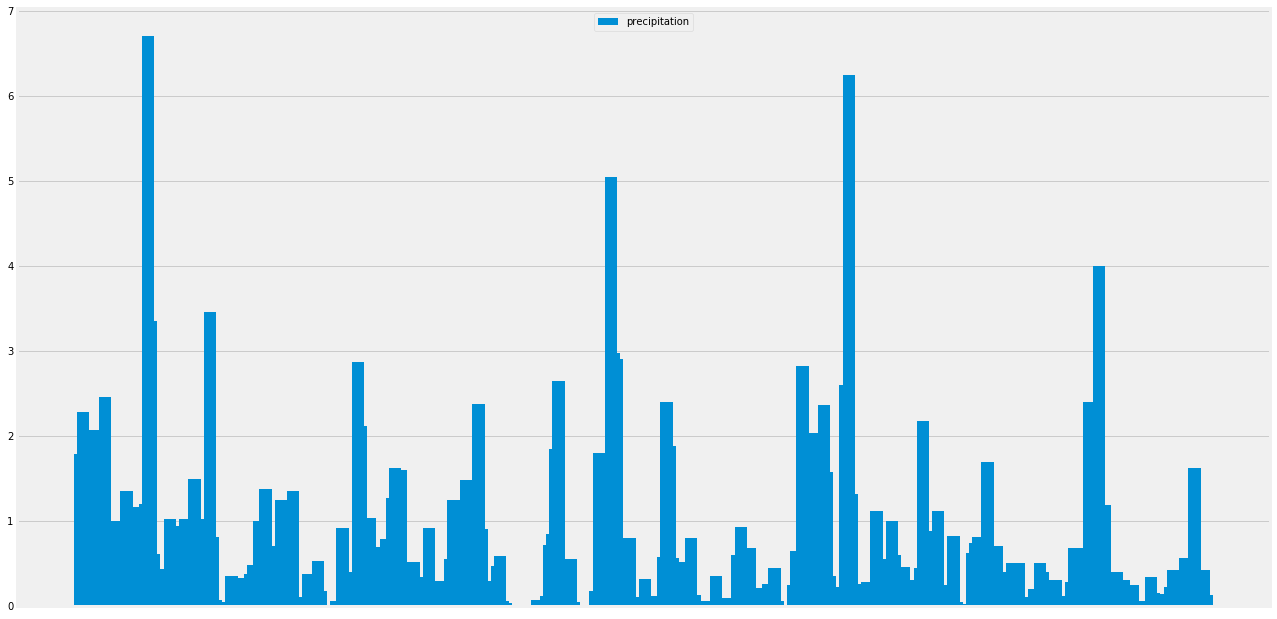

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
precipication_df = pd.read_sql_query(year_range_query.statement, engine, index_col='date')

dates = list(precipication_df.index)
fig = plt.gcf()
fig.set_size_inches(20, 11)
plt.grid(True)
plt.bar(dates, precipication_df['prcp'], width= 4, label="precipitation")
plt.legend(loc="upper center")
plt.xticks([])
plt.show()

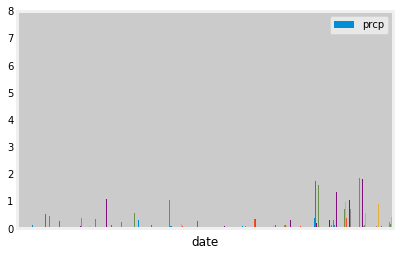

In [13]:
precipication_df = pd.read_sql_query(year_range_query.statement, engine)
precp_plot = precipication_df.plot(kind="bar", x="date", y="prcp", grid=True
              ).set_xticklabels([])
plt.ylim(0, 8)
plt.show()

In [63]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipication_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(Station.id)).all()
station_count

[(9)]

In [64]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.id)).\
                       group_by(Measurement.station).\
                                   order_by(func.count(Measurement.id).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [35]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                       group_by(Measurement.station).\
                                   order_by(func.count(Measurement.id).desc()).first()

(54.0, 85.0, 71.66378066378067)

In [65]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station 

#create a variable that will hold the tuple with the name of the station with the most observations
#to obtain this tuple we can reference the query used to order stations by most obseravtions 
#simply select the Measurement.station in the first row (which corresponds to the station with the most obeservations)
mobs_station = session.query(Measurement.station).\
                       group_by(Measurement.station).\
                                   order_by(func.count(Measurement.id).desc()).first()


#create a variable that will hold the date for the station with the most 
mobs_latest_date = session.query(Measurement.date).filter(Measurement.station == mobs_station[0]).\
                    order_by(Measurement.date.desc()).first()

#using a datetime class method we can transform our date string into a date object which allows us to better manipulate date values
# without being forced to hard-code 
mobs_latest_date_obj = dt.date.fromisoformat(mobs_latest_date[0])

#use timedelta method plus operations to create a date object referencing a year from latest date
yrfrm_latest_mobs_date = mobs_latest_date_obj - dt.timedelta(days=365)


mobs_station_yr_range_query = session.query(Measurement).\
               filter(Measurement.station == mobs_station[0]).\
                              filter(Measurement.date.between(str(yrfrm_latest_mobs_date), str(mobs_latest_date_obj)))



mobs_station_df = pd.read_sql(mobs_station_yr_range_query.statement, engine)
mobs_station_df.head()

,id,station,date,prcp,tobs
0,14603,USC00519281,2016-08-18,0.00,80.0
1,14604,USC00519281,2016-08-19,0.31,79.0
2,14605,USC00519281,2016-08-20,0.13,81.0
3,14606,USC00519281,2016-08-21,0.08,79.0
4,14607,USC00519281,2016-08-22,2.32,78.0


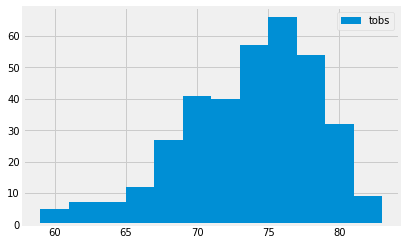

In [48]:
# plot the results as a histogram

plt.grid(True)
plt.hist(mobs_station_df['tobs'], bins=12, label="tobs")
plt.legend(loc="best")
plt.show()

In [176]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [177]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

""" TRIP DATA:
Provided I have a trip start date of "2017-01-01" and an end date of "2017-01-07"
The minimum, average, and maximum temperature would be: """

trip_temps = calc_temps("2017-01-01", "2017-01-07")
trip_temps

[(62.0, 68.36585365853658, 74.0)]

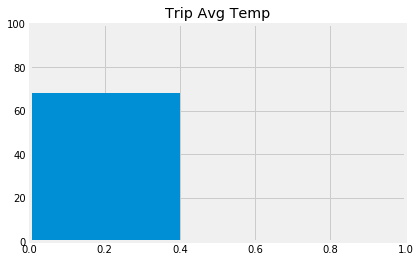

In [178]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.bar([0], trip_temps[0][1])

plt.title('Trip Avg Temp')
plt.axis([0, 1, 0, 100])
plt.show()

In [179]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


""" 
Provided I have a trip start date of "2017-01-01" and an end date of "2017-01-07"
The amount of rainfall(precipitation) per station would be: 
"""

session.query(Measurement.station, func.sum(Measurement.prcp)).\
        filter(Measurement.date >= "2017-01-01").filter(Measurement.date <= "2017-01-07").\
               group_by(Measurement.station).\
                       order_by(func.sum(Measurement.prcp).desc()).all()

[('USC00519523', 0.61),
 ('USC00514830', 0.6),
 ('USC00516128', 0.6),
 ('USC00513117', 0.35),
 ('USC00519281', 0.2),
 ('USC00519397', 0.0)]

## Optional Challenge Assignment

In [180]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [259]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start = "2017-01-01"
end = "2017-01-07"

# Use the start and end date to create a range of dates
full_date_list = session.query(Measurement.date).filter(Measurement.date.between(start, end))

# Stip off the year and save a list of %m-%d strings
# select a parsed dates from the date column based on dates falling between our start and end dates
date_list = session.query(func.strftime("%m-%d", Measurement.date)).filter(Measurement.date.between(start, end)).all()
uniq_dates = []
for date in date_list:
    if date[0] not in uniq_dates:
        uniq_dates.append(date[0])
    

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in uniq_dates:
    normals.append(daily_normals(date)[0])

normals

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [258]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

""" 
Designed a query that builds on the "return" of the daily_normals function

Note:
This query selects the minimum, average, and maximum temperature observations from the Measurement table...
where the month and date ("%m-%d") portion of the strings contained within the Measurement.date column match strings
contained within our uniq_dates list ...
This query then groups the resulting aggregate results by month and date ("%m-%d" )
This essentially gives you rows which correspond to results for every unique date value passed into the daily_normals function


"""

sel2 = [Measurement.date, func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]

daily_normal_query = session.query(*sel2).filter(func.strftime("%m-%d", Measurement.date).in_(uniq_dates)).\
             group_by(func.strftime("%m-%d", Measurement.date))

daily_normal_df = pd.read_sql(daily_normal_query.statement, engine, index_col='date')

daily_normal_df

,min_1,avg_1,max_1
date,,,
2011-01-01,62.0,69.153846,77.0
2014-01-02,60.0,69.396226,77.0
2010-01-03,62.0,68.909091,77.0
2010-01-04,58.0,70.000000,76.0
2010-01-05,56.0,67.964286,76.0
2010-01-06,61.0,68.964912,76.0
2016-01-07,57.0,68.543860,76.0


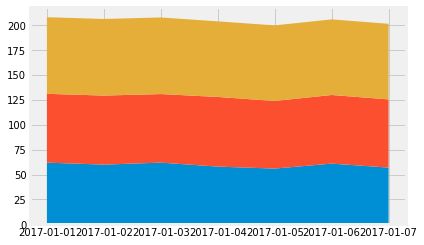

In [263]:
# Plot the daily normals as an area plot with `stacked=False`
x = asd
plt.stackplot(asd, daily_normal_df['min_1'], daily_normal_df['avg_1'], daily_normal_df['max_1'])

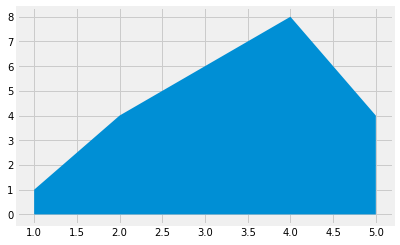

In [261]:
import numpy as np
import matplotlib.pyplot as plt
 
# Create data
x=range(1,6)
y=[1,4,6,8,4]
 
# Area plot
plt.fill_between(x, y)
plt.show()
 
# Note that we could also use the stackplot function:

# but fill_between is more convenient for future customization.


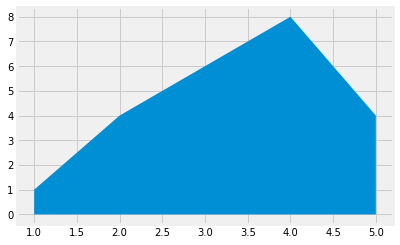

In [262]:
plt.stackplot(x,y)

In [250]:
session.query(Measurement.station, func.count(Measurement.date)).\
        filter(Measurement.date >= "2017-01-01").filter(Measurement.date <= "2017-01-16").\
               group_by(Measurement.station).\
                       order_by(func.sum(Measurement.prcp).desc()).all()

[('USC00516128', 16),
 ('USC00514830', 14),
 ('USC00519523', 12),
 ('USC00513117', 16),
 ('USC00519281', 16),
 ('USC00519397', 16),
 ('USC00517948', 5)]

In [195]:
sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
test = session.query(*sel).group_by(Measurement.date).having(func.strftime("%m-%d", Measurement.date).in_(uniq_dates)).all()

In [202]:
test2 = session.query(*sel).filter(func.strftime("%m-%d", Measurement.date).in_(uniq_dates)).\
             group_by(Measurement.date).\
                   having().all()

In [237]:
len(test2)

7

In [235]:
test2

[(62.0, 69.33333333333333, 74.0),
 (66.0, 69.2, 74.0),
 (63.0, 67.66666666666667, 73.0),
 (62.0, 67.16666666666667, 73.0),
 (63.0, 67.5, 72.0),
 (62.0, 67.66666666666667, 74.0),
 (66.0, 70.16666666666667, 72.0)]

In [198]:
uniq_dates

['01-01', '01-02', '01-03', '01-04', '01-05', '01-06', '01-07']

In [208]:
test2 = session.query(*sel).filter(Measurement.date.between(start, end)).\
             group_by(Measurement.date).all()

In [247]:
test2 = session.query(*sel).filter(func.strftime("%m-%d", Measurement.date).in_(uniq_dates)).\
             group_by(func.strftime("%m-%d", Measurement.date)).all()

In [248]:
test2

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [226]:
d = list(np.arange('2017-01-01', '2017-01-08', dtype='datetime64[D]'))

In [230]:
asd = list(np.datetime_as_string(d))
asd

['2017-01-01',
 '2017-01-02',
 '2017-01-03',
 '2017-01-04',
 '2017-01-05',
 '2017-01-06',
 '2017-01-07']

TypeError: strftime() missing required argument 'format' (pos 1)

In [243]:
session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == '01-01').group_by().all()

[(62.0, 69.15384615384616, 77.0)]

In [244]:
print(str(session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == '01-01')))

SELECT min(measurement.tobs) AS min_1, avg(measurement.tobs) AS avg_1, max(measurement.tobs) AS max_1 
FROM measurement 
WHERE strftime(?, measurement.date) = ?
